In [1]:
import os
import sys
sys.path.append("../")
import pathlib
import pylab as plt

import torch
from torch.nn import functional as F

import pytorch_lightning as pl
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule, MriModule
from train_enet import EnetModel
from train_shuffle_deeplab import DeepLabShuffleV2Model
from train_unet_smp import UnetSMPModel
pl.seed_everything(42)

42

In [2]:
mask = create_mask_for_mask_type('random', [0.08], [4])
train_transform = UnetDataTransform('singlecoil', mask_func=mask, use_seed=False)
val_transform = UnetDataTransform('singlecoil', mask_func=mask)
test_transform = UnetDataTransform('singlecoil')

data_module = FastMriDataModule(
    data_path=pathlib.Path('../../../fastMRIdatasets/'),
    challenge='singlecoil',
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    test_split='test',
    test_path=None,
    sample_rate=1.0,
    batch_size=15,
    num_workers=4,
    distributed_sampler=False)

model = EnetModel(
    in_chans=1,
    out_chans=1,
)

default_root_dir = pathlib.Path('enet')
checkpoint_path = pathlib.Path('enet/checkpoints')
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_top_k=True,
        verbose=True,
        monitor="validation_loss",
        mode="min",
        prefix="")

In [3]:
trainer = pl.Trainer(
    amp_backend='native',
    amp_level='O2',
    auto_lr_find=False,
    auto_scale_batch_size=False,
    auto_select_gpus=False,
    automatic_optimization=True,
    benchmark=False,
    check_val_every_n_epoch=1,
    checkpoint_callback=checkpoint_callback,
    default_root_dir=default_root_dir,
    deterministic=False,
    distributed_backend=None,
    fast_dev_run=False,
    flush_logs_every_n_steps=100,
    gpus=1,
)
# trainer.fit(model, datamodule=data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.00016345136072380107, 'norm': 0.054951201076405914, 'patient_id': '1e8c9978086d58437d66bf962ea8ffd8516022cb5d948d61f9137d684459efb9'}
complex64
(34, 640, 368)


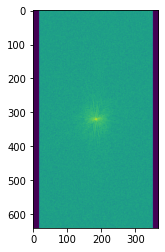

In [3]:
import h5py
import numpy as np
import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc
from matplotlib import pyplot as plt

file_name = '../../../fastMRIdatasets/singlecoil_train/file1000023.h5'
hf = h5py.File(file_name)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)
plt.imshow(np.log(np.abs(volume_kspace[20]) + 1e-9))
plt.show()

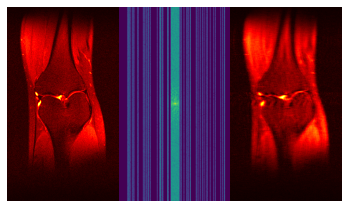

In [4]:
slice_kspace = T.to_tensor(volume_kspace[20])
slice_image = fastmri.ifft2c(slice_kspace)
slice_image_abs = fastmri.complex_abs(slice_image)

mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
# mask_func = EquispacedMaskFunc(center_fractions=[0.01], accelerations=[8])
masked_kspace, mask = T.apply_mask(slice_kspace, mask_func)
sampled_image = fastmri.ifft2c(masked_kspace)
sampled_image_abs = fastmri.complex_abs(sampled_image)
fig, ax = plt.subplots(ncols=3, 
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                       gridspec_kw=dict(wspace=0.0, hspace=0.0))
ax[0].imshow(np.abs(slice_image_abs), cmap='hot')
ax[1].imshow(np.log(np.abs(masked_kspace[:,:,0]) + 1e-9))
ax[2].imshow(np.abs(sampled_image_abs), cmap='hot')
plt.show()

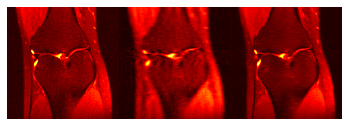

In [10]:
# model = EnetModel.load_from_checkpoint('../models/enet/checkpoints/epoch=4.ckpt')
# model = UnetModule.load_from_checkpoint('../../fastmri_examples/unet/unet/unet_demo/checkpoints/epoch=7.ckpt')
# model = DeepLabShuffleV2Model.load_from_checkpoint('../models/DeepLabShuffleV2/checkpoints/epoch=0.ckpt')
model = UnetSMPModel.load_from_checkpoint('../models/unet-densenet121/checkpoints/epoch=5.ckpt')

slice_image_abs = fastmri.complex_abs(fastmri.data.transforms.complex_center_crop(slice_image, (320, 320)))
sampled_image = fastmri.data.transforms.complex_center_crop(sampled_image, (320, 320))
sampled_image_abs = fastmri.complex_abs(sampled_image)
std = sampled_image_abs.std()
mean = sampled_image_abs.mean()

sampled_image_n = (sampled_image_abs - mean) / (std + 1e-8)
reconstructed_image = model(sampled_image_n.unsqueeze(0))[0].detach()
reconstructed_image = (reconstructed_image * std) + mean

fig, ax = plt.subplots(ncols=3, 
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                       gridspec_kw=dict(wspace=0.0, hspace=0.0))
ax[0].imshow(slice_image_abs, cmap='hot')
ax[1].imshow(sampled_image_abs, cmap='hot')
ax[2].imshow(reconstructed_image, cmap='hot')
plt.show()

In [11]:
sys.path.append('../../fastmri_examples/cs/')
sys.path.append('../../../bart-0.6.00/python/')
os.environ['TOOLBOX_PATH'] = os.path.abspath('../../../bart-0.6.00/')
from run_bart import SliceDataset, DataTransform, run_model, cs_total_variation

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [12]:
mask = create_mask_for_mask_type('random', [0.08], [4])

dataset = SliceDataset(
    root='../../../fastMRIdatasets/singlecoil_val/',
    transform=DataTransform(split='val', mask_func=mask, reg_wt=0.01),
    challenge='singlecoil',
    sample_rate=1.0
)

file1000263.h5


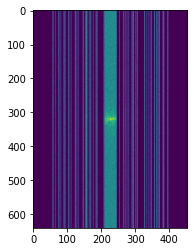

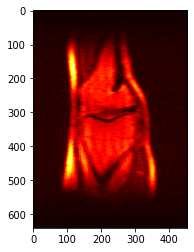

In [13]:
mrii = dataset[890]
print(mrii[2])
plt.imshow(torch.log(mrii[0][:,:,0].abs() + 1e-8))
plt.show()
slice_image = fastmri.ifft2c(mrii[0])
slice_image_abs = fastmri.complex_abs(slice_image)
plt.imshow(np.abs(slice_image_abs), cmap='hot')
plt.show()

In [14]:
print(mrii[1], mrii[4], mrii[5])

0.01 (320, 320) None


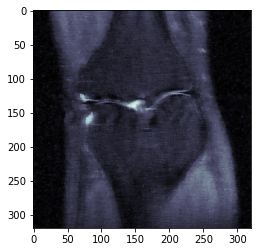

In [17]:
args = Namespace(challenge='singlecoil', num_iters=200)
prediction = cs_total_variation(args, masked_kspace, 0.01, (320, 320), None)
plt.imshow(prediction, cmap=plt.cm.bone)
plt.show()